In [1]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

# TLDR

Get the data

In [2]:
# OLD way
# # json file was already prepared with gribscan-index and gribscan-build command line tools
# resolution='tco3999-ng5'
# gribfiles='ICMGGall' 
# datapath='/work/bm1235/a270046/cycle2-sync/'+resolution+'/'+gribfiles
# datazarr=datapath+'/json.dir/atm2d.json' # all 2D surface fields, this is the whole dataset!
# data = xr.open_zarr("reference::"+datazarr, consolidated=False)

In [3]:
cat = intake.open_catalog("../catalog.yaml")
run = cat.IFS["tco3999-ng5"]
data = run.ICMGG_atm2d.to_dask()

Get the grid

In [4]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)

Interpolate

In [5]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_icon = np.vstack((lon_nonan, lat_nonan)).T
data_sample = data['2t'][1,:]

nn_interpolation = NearestNDInterpolator(points_icon, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

Plot

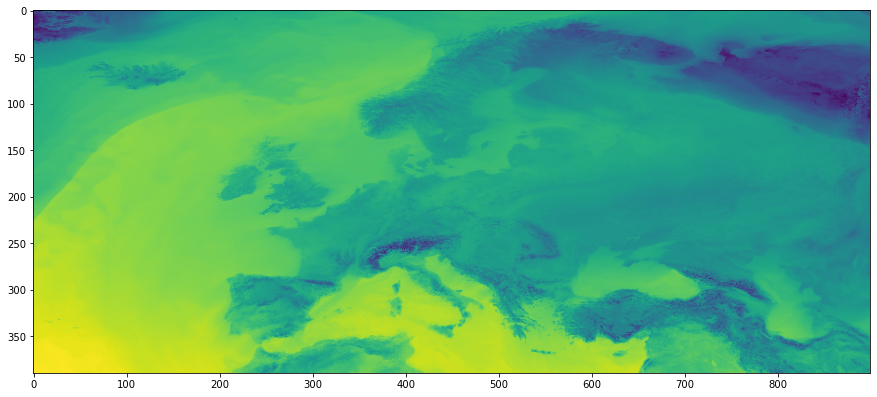

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Longer version

In [7]:
# OLD, not recomended version
# json file was already prepared with gribscan-index and gribscan-build command line tools
# resolution='tco3999-ng5'
# gribfiles='ICMGGall' 
# datapath='/work/bm1235/a270046/cycle2-sync/'+resolution+'/'+gribfiles
# datazarr=datapath+'/json.dir/atm2d.json' # all 2D surface fields, this is the whole dataset!
# data = xr.open_zarr("reference::"+datazarr, consolidated=False)

In [8]:
cat = intake.open_catalog("../catalog.yaml")
run = cat.IFS["tco3999-ng5"]
data = run.ICMGG_atm2d.to_dask()

In [9]:
data['2t']

<xarray.DataArray '2t' (time: 5401, value: 64144000)>
dask.array<open_dataset-247cb653fe75754ec8b2033d6fccf62e2t, shape=(5401, 64144000), dtype=float64, chunksize=(1, 64144000), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-09-01
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

look at the variables

In [10]:
# data.variables

In [11]:
data_sample = data['2t'][1,:]

In [12]:
data_sample

<xarray.DataArray '2t' (value: 64144000)>
dask.array<getitem, shape=(64144000,), dtype=float64, chunksize=(64144000,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [13]:
data_sample.shape

(64144000,)

In [14]:
data_sample.values

array([245.00733948, 244.98976135, 244.99562073, ..., 241.91944885,
       241.9389801 , 241.95265198])

Model Grid

In [15]:
model_lon = data.lon.values
model_lat = data.lat.values

In [16]:
model_lon.shape

(64144000,)

In [17]:
model_lon

array([  0.,  18.,  36., ..., 306., 324., 342.])

In [22]:
#not needed anymore
# nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))

In [19]:
#not needed anymore
# lat_nonan = model_lat[nonan]
# lon_nonan = model_lon[nonan]

In [30]:
# lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

Target grid

In [31]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

In [32]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

In [33]:
# points_icon = np.vstack((lon_nonan, lat_nonan)).T
points_icon = np.vstack((model_lon, model_lat)).T

In [34]:
nn_interpolation = NearestNDInterpolator(points_icon, data_sample.values[nonan])

In [35]:
interpolated_nn = nn_interpolation((lon2, lat2))

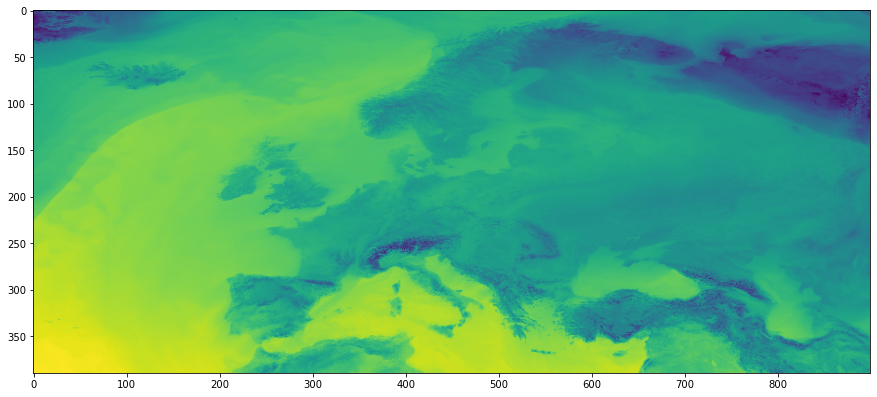

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find point on the map

In [37]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [38]:
lon_target = -10
lat_target = 50

In [39]:
points = np.array([[lat_target],[lon_target]])

In [40]:
# index = tunnel_fast1d(lon_nonan, lat_nonan, points)
index = tunnel_fast1d(model_lon, model_lat, points)

In [ ]:
# lon_nonan[index[0]]
model_lon[index[0]]

-10.0

In [43]:
# lat_nonan[index[0]]
model_lat[index[0]]

50.003124671337446

In [44]:
data['2t']

<xarray.DataArray '2t' (time: 5401, value: 64144000)>
dask.array<open_dataset-247cb653fe75754ec8b2033d6fccf62e2t, shape=(5401, 64144000), dtype=float64, chunksize=(1, 64144000), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-09-01
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [45]:
data['2t'][:, index[0]]

<xarray.DataArray '2t' (time: 5401)>
dask.array<getitem, shape=(5401,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-09-01
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

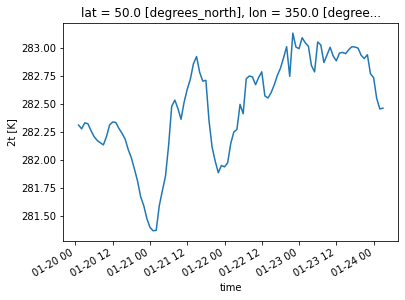

In [46]:
data['2t'][1:100, index[0]].plot()

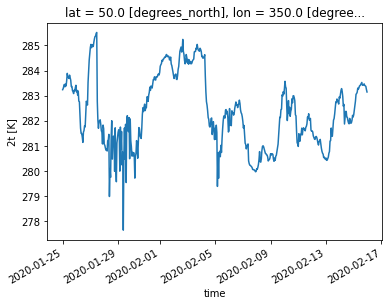

In [47]:
data['2t'].sel(time=slice('2020-01-25','2020-02-15'))[:,index[0]].plot()